<a href="https://colab.research.google.com/github/yashkens/NN_methods/blob/main/nn_methods_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import accuracy_score

### Скачивание и подготовка данных

In [3]:
data = pd.read_csv('Fake.csv')
data = data[['title', 'text', 'subject']]
data.head()


,title,text,subject
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News


In [4]:
def preprocess(text):
    words = wordpunct_tokenize(text.lower())
    return words

In [5]:
# удаление слишком длинных текстов
keep_inds = []
for ind, text in enumerate(data['text']):
  if len(preprocess(text)) < 2000:
    keep_inds.append(ind)

In [6]:
data = data.iloc[keep_inds]

In [7]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [8]:
target_labels = {}
values = set(data['subject'])
for i, value in enumerate(values):
  target_labels[value] = i

In [9]:
target_labels

{'Government News': 5,
 'Middle-east': 0,
 'News': 4,
 'US_News': 3,
 'left-news': 1,
 'politics': 2}

In [10]:
vocab = Counter()
for text in data['text']:
  tokens = preprocess(text)
  vocab.update(tokens)
print('Всего уникальных слов:', len(vocab))

Всего уникальных слов: 91530


In [11]:
filtered_vocab = set()
for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('Уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

Уникальных символов, втретившихся больше 5 раз: 31464


In [12]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE


device(type='cuda')

### Embeddings

Код ниже не нужно запускать - тут я создала файл с эмбеддингами только для нужных слов, чтобы сэкономить место.

In [19]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:19<00:00, 83.1MB/s]


In [20]:
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz

In [12]:
model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

In [34]:
pad = torch.empty(1, 300)
pad_emb = nn.init.xavier_uniform_(pad)[0]

In [ ]:
weights = []
weights.append(pad_emb.numpy())
word2id = {'PAD':0}

for word in filtered_vocab:
  if word in model:
    word2id[word] = len(word2id)
    weights.append(model[word])

weights = np.array(weights)
weights = torch.FloatTensor(weights)
id2word = {i:word for word, i in word2id.items()}

In [49]:
torch.save((weights, word2id, id2word), 'embeddings.pt')

Запускайте отсюда - загрузка эмбеддингов

In [13]:
weights, word2id, id2word = torch.load('embeddings.pt')

### Dataset & DataLoader

In [14]:
class NewsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.texts = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['subject'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = preprocess(self.texts[index])
        ids = torch.LongTensor([self.word2id[symbol] for symbol in tokens if symbol in self.word2id])
        y = target_labels[self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device).to(torch.long)
      return padded_ids, y

In [15]:
val_dataset = NewsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [16]:
train_dataset = NewsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

### Model

In [17]:
class CLSTM(nn.Module):
    
    def __init__(self, weights, num_classes):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.dropout1 = nn.Dropout(0.5)
        self.cnn = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=150, hidden_size=150, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.linear = nn.Linear(in_features=150, out_features=num_classes)
        self.softmax = nn.Softmax()

    def forward(self, words):
        embedded = self.embedding(words)
        embedded = self.dropout1(embedded)
        embedded = embedded.transpose(1, 2)

        hidden = self.cnn(embedded)
        hidden = self.relu(hidden)
        hidden = hidden.transpose(1, 2)

        hidden, _ = self.lstm(hidden)
        hidden = hidden[:,-1,:]
        hidden = self.dropout2(hidden)

        out = self.linear(hidden)
        # out = self.softmax(out)   
        return out

In [18]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')

In [19]:
model = CLSTM(weights, num_classes=len(target_labels))
output = model(batch)
# print(output)

In [19]:
output.shape

torch.Size([64, 6])

In [57]:
loss = nn.CrossEntropyLoss()
loss(output, y)

tensor(1.8070, grad_fn=<NllLossBackward0>)

In [65]:
accuracy_score(np.argmax(output.detach().cpu().numpy(), axis=-1), y.detach().cpu().numpy())

0.1875

### Training loop

In [20]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys) 
            epoch_loss += loss.item()
            batch_metric = accuracy_score(np.argmax(preds.detach().cpu().numpy(), axis=-1),
                                          ys.detach().cpu().numpy())
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val Acc: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [28]:
model = CLSTM(weights, len(target_labels))
criterion = nn.CrossEntropyLoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [29]:
layers = [{'params': [param for name, param in model.named_parameters() if 'linear' not in name]}, 
          {'params': model.linear.parameters(), 'weight_decay': 0.001}]

In [30]:
optimizer = optim.RMSprop(layers)

In [31]:
epochs = 5

In [32]:
losses = []
losses_eval = []
scores = []
scores_eval = []

for i in range(epochs):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    acc_on_train,_ = evaluate(model, train_iterator, criterion)
    scores.append(acc_on_train)
    print('\nEvaluating on test...')
    acc_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    scores_eval.append(acc_on_test)


starting Epoch 0
Training...
Train loss: 1.8343641590653805
Train loss: 1.665588000546331
Train loss: 1.610275950045944
Train loss: 1.5730732441980602
Train loss: 1.5499780149195845

Evaluating on train...
Val loss: 1.4228830483921788, Val Acc: 0.4018640350877193
Val loss: 1.4159265507822452, Val Acc: 0.3995923913043478
Val loss: 1.421325375578996, Val Acc: 0.3949602601156069
Val loss: 1.4176748758786684, Val Acc: 0.3953598484848485
Val loss: 1.4149343856065744, Val Acc: 0.39718633707645096

Evaluating on test...
Val loss: 1.5184595401470478, Val Acc: 0.4483173076923077
Val loss: 1.4640392153351396, Val Acc: 0.4010416666666667
Val loss: 1.4539957424489462, Val Acc: 0.3944359756097561
Val loss: 1.4421294342387807, Val Acc: 0.396875
Val loss: 1.4404623698497163, Val Acc: 0.395606884057971

starting Epoch 1
Training...
Train loss: 1.4492014416477137
Train loss: 1.4272322343743367
Train loss: 1.4194356733663922
Train loss: 1.411961767580602
Train loss: 1.4138254636711727

Evaluating on tr

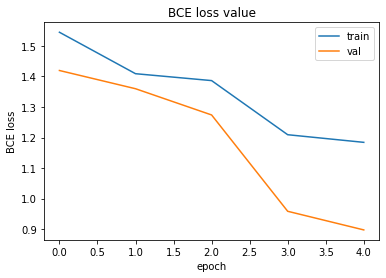

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

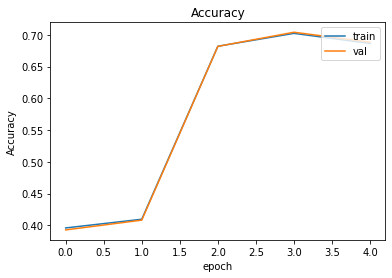

In [36]:
plt.plot(scores)
plt.plot(scores_eval)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [54]:
def predict(model, iterator):
    model.eval()
    right = []
    wrong = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator), total=len(iterator)):   
            preds = model(texts).detach().cpu().numpy()
            for pred, gold, text in zip(preds, ys, texts):
              pred = np.argmax(pred, axis=-1)
              text = ' '.join([id2word[int(symbol)] for symbol in text if symbol !=0])
              if pred == gold:
                right.append((text, gold.item(), pred))
              elif pred != gold:
                wrong.append((text, gold.item(), pred))
            if i > 10:
              break
    return right, wrong

In [55]:
right, wrong = predict(model, val_iterator)

 15%|█▌        | 11/73 [00:45<04:17,  4.15s/it]


In [58]:
target_labels

{'Government News': 5,
 'Middle-east': 0,
 'News': 4,
 'US_News': 3,
 'left-news': 1,
 'politics': 2}

In [59]:
label2id = {value:key for key, value in target_labels.items()}

In [61]:
print(f'{wrong[0][0]}\nGold:{label2id[wrong[0][1].item()]}\nPred:{label2id[wrong[0][2]]}')

fox news reporter mike interviewed former new black panther leader malik who promised violence on the republican national convention malik from what i know many the groups on the left mainly the white left others i know for fact that there s going be the blocking highways there s going be arrests there s going be some things i hear that s going go on next week it s highly likely there s going be arrests there s going be tear gas it s going be happening this is the same man who called police officers occupiers
Gold:left-news
Pred:politics


In [62]:
print(f'{wrong[5][0]}\nGold:{label2id[wrong[5][1].item()]}\nPred:{label2id[wrong[5][2]]}')

with % mexico now living in america americans should be demanding our president tell us why he allowed these illegal aliens cross our southern border who will pay for their health care education americans pride ourselves on being people who have government but these days it more often seems as if we ve got government that has people that government is even selecting who its people will be having within generation essentially imported state s worth new people through immigration since the number hispanics mexican origin in the u s has jumped from fewer than 1 million more than million if all these mexicans were state it would be the second largest in population in the country trailing only california did you vote approve that immigration policy did anyone in fact the federal government allowed it happen without any voter input that s by design in recent years congress has attempted draft legislation deal with illegal immigration while the controversial gang eight bill passed the senate 

In [63]:
print(f'{wrong[10][0]}\nGold:{label2id[wrong[10][1].item()]}\nPred:{label2id[wrong[10][2]]}')

fox 2 the tv station that appears be sympathetic the black lives matter riots in st louis found themselves on the wrong side angry protesters today after the innocent verdict for st louis police officer jason came down today in the murder trial anthony lamar smith fox 2 news showed their solidarity with the movement when they retweeted couple tweets by one the leaders the terror group both s tweets were intended mock the decision made by judge timothy wilson exonerate is murderer # should be alive today pic twitter com september is the second retweet by fox news this from the judge in the case officer # who killed # pic twitter com september fox news also pointed out in seperate tweet that st louis police officers were using mace control the crowd police use mace in confrontation with protesters in downtown st louis https t co pic twitter com september fox 2 news got surprise however when they attempted infiltrate the protesters found themselves in the middle situation that could have 

In [75]:
def predict_all(model, iterator):
    model.eval()
    all_preds = []
    all_golds = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator), total=len(iterator)):   
            preds = model(texts).detach().cpu().numpy()
            preds = np.argmax(preds, axis=-1)
            all_golds.append(ys.cpu().numpy())
            all_preds.append(preds)
    all_preds = np.concatenate(all_preds)
    all_golds = np.concatenate(all_golds)
    return all_preds, all_golds

In [76]:
all_preds, all_golds = predict_all(model, val_iterator)

100%|██████████| 73/73 [00:07<00:00,  9.14it/s]


In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [81]:
c = confusion_matrix(all_golds, all_preds)
c = c/c.sum(axis=-1)

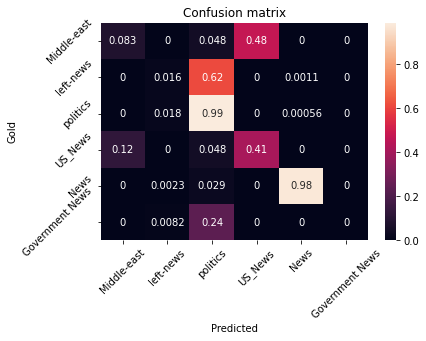

In [87]:
ax = sns.heatmap(c, annot=True)
ax.set_xticklabels(target_labels.keys(), rotation=45)
ax.set_yticklabels(target_labels.keys(), rotation=45)
ax.set_title('Confusion matrix')
ax.set_ylabel('Gold')
ax.set_xlabel('Predicted')
plt.show()

In [88]:
np.unique(all_golds, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 145,  857, 1364,  141, 1799,  332]))

Классы, которых изначально было меньше в данных, модель выучила плохо.